<a href="https://colab.research.google.com/github/HarishSingh1981/LearningNeuralNetwork/blob/main/S7_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as Alb

In [ ]:
class My_Transforms:
    def __init__(self, transforms: Alb.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
batch_size = 50
use_cuda = torch.cuda.is_available()
kwargs_train = dict(num_workers= 4, pin_memory= True if use_cuda else False,shuffle=True,batch_size=batch_size)
kwargs_test = dict(num_workers= 4, pin_memory= True if use_cuda else False,shuffle=False,batch_size=batch_size)

TrainTransform = Alb.Compose([Alb.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                            Alb.HorizontalFlip(),Alb.ShiftScaleRotate(),
                            Alb.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.5,0.5,0.5),mask_fill_value=None)])
transform = My_Transforms(TrainTransform)

#why we need normalized test data
TestTransform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     Alb.HorizontalFlip(),
     Alb.ShiftScaleRotate(),
     Alb.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.5,0.5,0.5),mask_fill_value=None)])
'''
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **kwargs_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=TestTransform)
testloader = torch.utils.data.DataLoader(testset, **kwargs_test)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



images data type <class 'dict'> and type of label <class 'torch.Tensor'>
images data type <class 'list'> and type of label <class 'torch.Tensor'> and size of image 1 and shape of image torch.Size([50, 32, 32, 3])
images data type <class 'torch.Tensor'> and type of label <class 'torch.Tensor'>
  car  frog  ship  frog  deer horse  frog  deer   car plane  frog   cat  deer  frog plane   cat   dog  bird  ship  ship   cat   cat  ship  bird  deer   dog truck   cat truck  frog  frog  deer   cat  deer  frog plane   cat  bird   car   dog truck truck plane truck truck horse truck  deer  frog horse


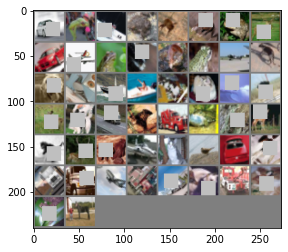

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow_cifar(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'images data type {type(images)} and type of label {type(labels)}')
images = list(images.values())
print(f'images data type {type(images)} and type of label {type(labels)} and size of image {len(images)} and shape of image {images[0].shape}')
images = images[0]
print(f'images data type {type(images)} and type of label {type(labels)}')

# show images
imshow_cifar(torchvision.utils.make_grid(np.transpose(images,(0,3,1,2))))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
!pip install torchsummary

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#attempt 3
!pip install torchsummary
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class My_Net(nn.Module):
    def __init__(self):
        super(My_Net, self).__init__()
        '''
        j_out = j_in * stride
        nout = (n_in + 2*p-k)/s + 1
        rf_out = rf_in + (k-1)*j_in
        '''
        #input 3x32x32 -? OUtput 6x28x28? RF 5
        self.c1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
                                      nn.BatchNorm2d(6),
                                      nn.ReLU())
                                      #nn.Dropout2d(0.5))
        #input 6x28x28 -? OUtput 6x20x20? RF 13
        self.transitionBlock1 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5,dilation=2),
                                      nn.BatchNorm2d(6),
                                      nn.ReLU())
        #input 6x20x20 -? OUtput 16x20x20? RF 17
        self.c2 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5,padding=2),
                                      nn.BatchNorm2d(12),
                                      nn.ReLU())
                                      #nn.Dropout2d(0.5))
        #input 12x20x20 -? OUtput 12x12x12? RF 33
        #self.transitionBlock1 = nn.MaxPool2d(2,2)
        self.transitionBlock2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5,dilation=4,padding=4),
                                      nn.BatchNorm2d(12),
                                      nn.ReLU())

        #input 12x12x12 -? OUtput 16x8x8? RF 37
        self.c3 = nn.Sequential(nn.Conv2d(12,16,5),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU())
                                      #nn.Dropout2d(0.5))

        #input 16x8x8 -? OUtput 10x4x4? RF 45
        self.c4 = nn.Sequential(nn.Conv2d(16,16,5,groups=16),
                                nn.Conv2d(16,10,1),
                                nn.BatchNorm2d(10),
                                nn.ReLU())
                                #nn.Dropout2d(0.5))               
        self.avgPoolblk = nn.AvgPool2d(4,4)
        self.fc = nn.Linear(12,10)
    def forward(self, x):
      #maxpool must be used at least after 2 convolution and sud be as far as possible from last layer
        #x = x.to('cuda')
        x = self.c1(x)
        x = self.transitionBlock1(x)
        x = self.c2(x)
        x = self.transitionBlock2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.avgPoolblk(x)
    #    print(f'shape of x after GAP is {x.shape}')
        x = x.view(-1, 10)
       # x = self.fc(x)
        return x

if torch.cuda.is_available():
  my_model = My_Net().to('cuda')
else :
  my_model = My_Net()
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
#model = Net().to(device)
summary(my_model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
            Conv2d-4            [-1, 6, 20, 20]             906
       BatchNorm2d-5            [-1, 6, 20, 20]              12
              ReLU-6            [-1, 6, 20, 20]               0
            Conv2d-7           [-1, 12, 20, 20]           1,812
       BatchNorm2d-8           [-1, 12, 20, 20]              24
              ReLU-9           [-1, 12, 20, 20]               0
           Conv2d-10           [-1, 12, 12, 12]           3,612
      BatchNorm2d-11           [-1, 12, 12, 12]              24
             ReLU-12           [-1, 12, 12, 12]               0
    

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = list(inputs.values())
        inputs = inputs[0]
        inputs = np.transpose(inputs,(0,3,1,2))

        if torch.cuda.is_available():
          inputs = inputs.to('cuda')
          labels = labels.to('cuda')
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = my_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print(f'Value of i is {i}')
        if i % 160 == 159:    # print every 160 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 160))
            running_loss = 0.0

print('Finished Training')

[1,   160] loss: 1.730
[1,   320] loss: 1.708
[1,   480] loss: 1.693
[1,   640] loss: 1.713
[1,   800] loss: 1.689
[1,   960] loss: 1.667
[2,   160] loss: 1.654
[2,   320] loss: 1.682
[2,   480] loss: 1.647
[2,   640] loss: 1.648
[2,   800] loss: 1.656
[2,   960] loss: 1.649
[3,   160] loss: 1.628
[3,   320] loss: 1.642
[3,   480] loss: 1.639
[3,   640] loss: 1.613
[3,   800] loss: 1.623
[3,   960] loss: 1.610
[4,   160] loss: 1.610
[4,   320] loss: 1.600
[4,   480] loss: 1.585
[4,   640] loss: 1.598
[4,   800] loss: 1.605
[4,   960] loss: 1.587
[5,   160] loss: 1.584
[5,   320] loss: 1.586
[5,   480] loss: 1.565
[5,   640] loss: 1.570
[5,   800] loss: 1.574
[5,   960] loss: 1.576
[6,   160] loss: 1.556
[6,   320] loss: 1.578
[6,   480] loss: 1.541
[6,   640] loss: 1.557
[6,   800] loss: 1.553
[6,   960] loss: 1.542
[7,   160] loss: 1.547
[7,   320] loss: 1.543
[7,   480] loss: 1.546
[7,   640] loss: 1.556
[7,   800] loss: 1.525
[7,   960] loss: 1.520
[8,   160] loss: 1.525
[8,   320] 

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog


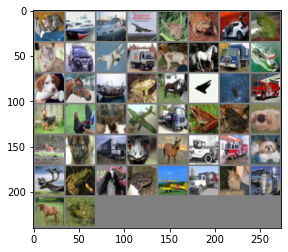

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

#images = list(images.values())
#images = images[0]
#images = np.transpose(images,(0,3,1,2))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
if torch.cuda.is_available():
  outputs = my_model(images.to('cuda'))
else :
  outputs = my_model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    dog   car  ship  ship  deer  frog   car  deer   dog   car plane truck  frog horse   car  ship   dog   cat  ship   cat horse plane plane truck  bird  frog  frog  deer   car  frog  frog horse  deer   cat truck   cat  frog   car truck   cat plane  deer   dog  frog plane truck   cat horse  deer  bird


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.to('cuda')
          labels = labels.to('cuda')
        outputs = my_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.to('cuda')
          labels = labels.to('cuda')

        outputs = my_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 60 %
Accuracy of  bird : 21 %
Accuracy of   cat : 18 %
Accuracy of  deer : 39 %
Accuracy of   dog : 37 %
Accuracy of  frog : 67 %
Accuracy of horse : 58 %
Accuracy of  ship : 50 %
Accuracy of truck : 50 %
